In [1]:
import pickle
vectors50, labels = pickle.load(open('vectors_tfidf_dim50.pkl', 'rb'))
vectors100, labels = pickle.load(open('vectors_tfidf_dim100.pkl', 'rb'))
#vectors, labels = pickle.load(open('vectors_doc2vec_dim50.pkl', 'rb'))
dictionary, labels_text = pickle.load(open('dictionary_labels_text.pkl', 'rb'))



In [2]:
import numpy as np

### Code for train and eval models

In [3]:
from collections import Counter
alllabels=[]
for x in labels:
    alllabels.extend(x)
labels_count=Counter(alllabels)
print (labels_count)

Counter({4: 3178, 9: 3167, 3: 2942, 10: 1388, 11: 1259, 5: 810, 2: 716, 8: 705, 1: 652, 0: 455, 6: 314, 7: 314})


In [4]:
len(alllabels)

15900

In [5]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier  


def make_singlelabel(Y):
    singlelabel_Y = []
    for y in Y:
        if len(y)>1:
            min_yitem_count = 1000000000
            min_yitem = -1
            for yitem in y:
                if min_yitem_count > labels_count[yitem]:
                    min_yitem = yitem
                    min_yitem_count = labels_count[yitem]
            singlelabel_Y.append(min_yitem)
        else:
            singlelabel_Y.append(y[0])
    return np.array(singlelabel_Y)

print (make_singlelabel([list([4,10]), list([9])]))
                  
def train(X, Y, modelname):
    y=make_singlelabel(Y)
    #y=lb.transform(y)
    
    if modelname=='svc':
        clf = SVC(kernel='sigmoid', gamma='auto')
    elif modelname=='nb':
        clf = GaussianNB()
    elif modelname=='dummy':
        clf = DummyClassifier(strategy='stratified')
    elif modelname=='dtree':
        clf = DecisionTreeClassifier()
    elif modelname=='forest':
        clf = RandomForestClassifier(n_estimators=100, random_state=1)
    elif modelname=='regression':
        clf = LogisticRegression()#multi_class='multinomial'
    elif modelname=='xgb':
        clf = XGBClassifier(n_estimators=300, objective='multi:softmax')#multi_class='multinomial'
    elif modelname=='ensemble':
        #clf1 = SVC(kernel='sigmoid', gamma='auto')
        #clf2 = GaussianNB()
        clf5 = XGBClassifier(n_estimators=300, objective='multi:softmax')
        clf6 = RandomForestClassifier(n_estimators=100, random_state=1)
        #clf4 = LogisticRegression()#multi_class='multinomial'
        clf = VotingClassifier(estimators=[('xgb', clf5), ('forest', clf6)], voting='hard')#('nb', clf2), ('regression', clf4)
    else:
        print ('ERROR!')
    clf.fit(X, y) 
    
    return clf

def predict(model, X, Y):
    y=make_singlelabel(Y)
    #y=lb.transform(y)
    
    yhat=model.predict(X)
    return y, yhat



[10  9]


In [6]:
#from sklearn import preprocessing
#lb = preprocessing.LabelBinarizer()
#lb.fit(make_singlelabel(labels))


### Code for CV

In [7]:
evalres100_folds = {}
evalres50_folds = {}


In [15]:

    
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=18) # Because we are Pier-18!

print(kf)  
for modelname in ['nb','forest']:#['nb','regression','ensemble','dummy']:
    print (modelname)
    evalres50_folds[modelname]=[]
    evalres100_folds[modelname]=[]
    for train_index, test_index in kf.split(vectors50):
        X_train, X_test = vectors50[train_index], vectors50[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model = train(X_train, y_train, modelname)
        print (model)
        evalres50_folds[modelname].append(predict(model, X_test, y_test))
        print (evalres50_folds[modelname])
        break
        
    for train_index, test_index in kf.split(vectors100):
        X_train, X_test = vectors100[train_index], vectors100[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model = train(X_train, y_train, modelname)
        print (model)
        evalres100_folds[modelname].append(predict(model, X_test, y_test))
        print (evalres100_folds[modelname])
        
        break
    
print ('done!')

KFold(n_splits=5, random_state=18, shuffle=True)
nb
GaussianNB(priors=None, var_smoothing=1e-09)
[(array([2, 5, 3, ..., 9, 4, 3]), array([2, 5, 5, ..., 9, 6, 3]))]
GaussianNB(priors=None, var_smoothing=1e-09)
[(array([2, 5, 3, ..., 9, 4, 3]), array([2, 5, 5, ..., 1, 9, 3]))]
forest
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
[(array([2, 5, 3, ..., 9, 4, 3]), array([ 2,  3,  3, ..., 10,  4,  3]))]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_

In [111]:
X_train

array([[-1.00706217e-01,  5.67078027e-02,  1.94087888e-03, ...,
        -8.45242803e-03,  2.32977395e-02,  1.55347247e-02],
       [-2.54286596e-02,  8.67178293e-02,  4.56389482e-03, ...,
        -7.78614280e-02,  1.48503103e-02,  1.39412289e-02],
       [ 1.48575566e-01,  8.62192256e-02,  9.42250185e-03, ...,
         8.40654374e-03, -3.66209641e-03,  2.33107961e-02],
       ...,
       [-2.69833814e-03, -1.58833089e-04, -7.03830139e-02, ...,
         5.88438753e-03, -1.79958700e-02,  6.02105176e-03],
       [-5.97262809e-03, -4.35439967e-02, -4.81422765e-02, ...,
         5.21370585e-03,  1.98452499e-02,  7.80656016e-03],
       [ 2.55597709e-01,  9.45044557e-02, -6.24715081e-03, ...,
        -1.00710155e-02, -1.11492637e-02,  1.16715329e-02]])

In [16]:
# Now evaluate
from sklearn.metrics import accuracy_score, classification_report

result50={}
result100={}
for modelname in evalres50_folds:
    print (modelname)
    for evalres_fold in evalres50_folds[modelname]:
        y, yhat = evalres_fold
        result50[modelname]=classification_report(y, yhat, output_dict=True)
        print (classification_report(y, yhat))
        break

for modelname in evalres100_folds:
    print (modelname)
    for evalres_fold in evalres100_folds[modelname]:
        y, yhat = evalres_fold
        result100[modelname]=classification_report(y, yhat, output_dict=True)
        print (classification_report(y, yhat))
        break

nb
              precision    recall  f1-score   support

           0       0.31      0.50      0.38        84
           1       0.12      0.12      0.12       112
           2       0.78      0.73      0.75       154
           3       0.74      0.52      0.61       585
           4       0.81      0.64      0.71       643
           5       0.28      0.15      0.20       180
           6       0.13      0.60      0.21        58
           7       0.39      0.39      0.39        67
           8       0.67      0.67      0.67       140
           9       0.58      0.80      0.67       641
          10       0.63      0.53      0.57       268
          11       0.78      0.55      0.65       239

   micro avg       0.58      0.58      0.58      3171
   macro avg       0.52      0.52      0.50      3171
weighted avg       0.64      0.58      0.59      3171

forest
              precision    recall  f1-score   support

           0       0.40      0.21      0.28        84
           1  

nb micro avg 0.5846736045411542
forest micro avg 0.7092399873856827


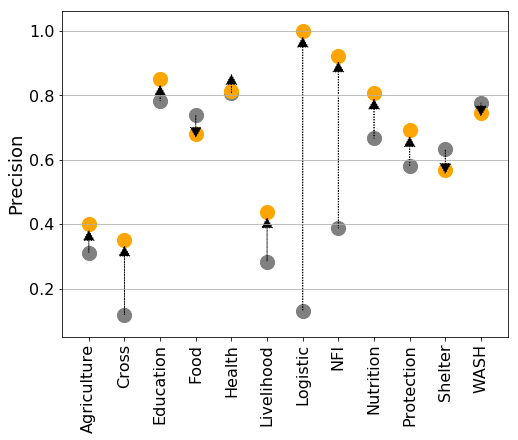

In [113]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6)) 

modelname = list(result50.keys())[0]
_labelids=[x for x in result50[modelname].keys()][:12]
_labeltexts=[]
for _lid in _labelids:
    _found=False
    for _ltext in labels_text:
        if str(labels_text[_ltext])==_lid:
            _labeltexts.append(_ltext)
            _found=True
    if not _found:
        if _lid == 'micro avg':
            _labeltexts.append('Micro Avg')
        elif _lid == 'macro avg':
            _labeltexts.append('Macro Avg')
        elif _lid == 'weighted avg':
            _labeltexts.append('Weighted Avg')
        else:
            _labeltexts.append(_lid)
colors={'nb':'gray','forest':'orange'}
for modelname in ['nb','forest']:
    _res=[result50[modelname][x]['precision'] for x in _labelids]
    print (modelname, 'micro avg', result50[modelname]['micro avg']['precision'])
        
    #plt.scatter(k, scores['test_accuracy'])
    plt.scatter(_labeltexts, _res, s=200, color=colors[modelname])

    
for i in range(len(_labeltexts)):
    _res1=result50['nb'][str(i)]['precision']
    _res2=result50['forest'][str(i)]['precision']
    if _res2>_res1+0.05:
        plt.arrow(i, _res1, 0, _res2-_res1-0.05, head_width=0.3, head_length=0.03, fc='k', ec='k', ls=':', lw=1)
    else:
        plt.arrow(i, _res1, 0, _res2-_res1+0.02, head_width=0.3, head_length=0.03, fc='k', ec='k', ls=':', lw=1)
        #x[-n], y[-n],
        #                 (x[-n+1]-x[-n])/100., (y[-n+1]-y[-n])/100.,
        #                 fc="k", ec="k",
        #                 head_width=0.1*linewidth, head_length=0.1*linewidth) 
    
#plt.scatter(k, scores['test_recall_macro'])
plt.ylabel("Precision", fontsize=18)
#plt.xlabel("Class", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)

ax = plt.axes()
ax.yaxis.grid(True)
#plt.set_xlim(0, max_x)

#plt.title("10 Folds Cross Validation")
#plt.legend(['f1_weighted', 'Testing Precision', 'Testing Recall'], loc='upper left')
plt.xticks(rotation=90)
plt.show()

In [93]:
_labelids

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

[455, 652, 716, 2942, 3178, 810, 314, 314, 705, 3167, 1388, 1259]


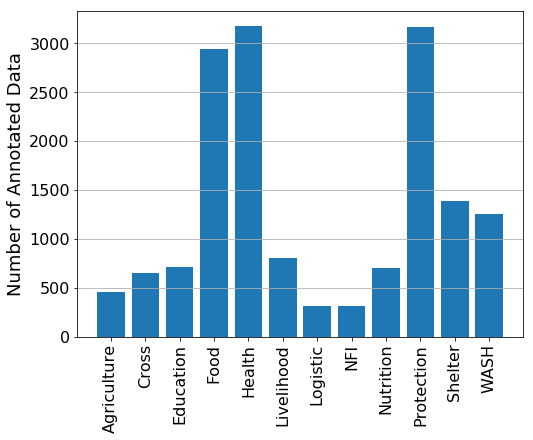

In [95]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6)) 

modelname = list(result50.keys())[0]
_labelids=[x for x in result50[modelname].keys()][:12]
_labeltexts=[]
for _lid in _labelids:
    _found=False
    for _ltext in labels_text:
        if str(labels_text[_ltext])==_lid:
            _labeltexts.append(_ltext)
            _found=True
    if not _found:
        if _lid == 'micro avg':
            _labeltexts.append('Micro Avg')
        elif _lid == 'macro avg':
            _labeltexts.append('Macro Avg')
        elif _lid == 'weighted avg':
            _labeltexts.append('Weighted Avg')
        else:
            _labeltexts.append(_lid)

_res=[labels_count[int(x)] for x in _labelids]
print (_res)
plt.bar(_labeltexts, _res)
    
#plt.scatter(k, scores['test_recall_macro'])
plt.ylabel("Number of Annotated Data", fontsize=18)
#plt.xlabel("Class", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)

ax = plt.axes()  
ax.yaxis.grid(True)
#plt.set_xlim(0, max_x)


#plt.title("10 Folds Cross Validation")
#plt.legend(['f1_weighted', 'Testing Precision', 'Testing Recall'], loc='upper left')
plt.xticks(rotation=90)
plt.show()